In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.model_selection import train_test_split

class SimpleHNN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=100, num_layers=3):
        super(SimpleHNN, self).__init__()

        self.input_dim = input_dim

        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.Tanh())

        layers.append(nn.Linear(hidden_dim, hidden_dim))
        layers.append(nn.Tanh())

        layers.append(nn.Linear(hidden_dim, 1))

        self.network = nn.Sequential(*layers)

        for layer in self.network:
        #инициализируем веса линейных слоев как ортогональные матрицы для улучшения стабильности обучения
            if isinstance(layer, nn.Linear):
                nn.init.orthogonal_(layer.weight)

    def hamiltonian(self, coords):
        return self.network(coords)

    def forward(self, coords):
        # Убеждаемся, что coords требует градиенты
        if not coords.requires_grad: #включаем отслеживание градиентов для тензора
            coords = coords.clone().requires_grad_(True)

        H = self.hamiltonian(coords)

        grad_H = torch.autograd.grad(
            outputs=H.sum(),
            inputs=coords,
            create_graph=True,
            retain_graph=True
        )[0]

        dH_dq = grad_H[:, :1]
        dH_dp = grad_H[:, 1:]

        dq_dt = dH_dp
        dp_dt = -dH_dq

        return torch.cat([dq_dt, dp_dt], dim=1)

    def predict_no_grad(self, coords):
        """
        Альтернативный метод для инференса без обратного распространения
        Но всё равно вычисляет градиенты для динамики!
        """
        with torch.enable_grad():  # Градиенты включены внутри этого блока
            coords_grad = coords.clone().requires_grad_(True)
            return self.forward(coords_grad).detach()


In [2]:
k = 1.0    # Жёсткость пружины
m = 1.0    # Масса груза
omega = np.sqrt(k/m)  # Собственная частота

# Функция для вычисления производных (уравнения Гамильтона)
def spring_hamiltonian(t, state):
    q, p = state
    dqdt = p / m  # dq/dt = ∂H/∂p
    dpdt = -k * q  # dp/dt = -∂H/∂q
    return [dqdt, dpdt]

In [3]:
#функция для генерации данных
def generate_harmonic_oscillator_data(num_trajectories=100, points_per_traj=100, noise_std=0.01):
    initial_conditions = []
    #задаём начальные данные для обучающей выборки
    for _ in range(num_trajectories):
        amplitude = np.random.uniform(0.5, 2.0)
        phase = np.random.uniform(0, 2*np.pi)

        # Начальные условия: q0 = A*cos(φ), p0 = -m*ω*A*sin(φ)
        q0 = amplitude * np.cos(phase)
        p0 = -m * omega * amplitude * np.sin(phase)
        initial_conditions.append([q0, p0])

    # Временной интервал
    t_span = [0, 4*np.pi/omega]  # Два полных периода
    t_eval = np.linspace(t_span[0], t_span[1], points_per_traj)

    # Решаем ОДУ для каждого начального условия
    all_states = []
    all_dstates = []

    for ic in initial_conditions:
        sol = solve_ivp(spring_hamiltonian, t_span, ic, t_eval=t_eval, method='RK45')

        # Состояния и производные
        states = np.vstack([sol.y[0], sol.y[1]]).T  # [q, p]
        dstates = np.array([spring_hamiltonian(t, state) for t, state in zip(sol.t, states)])

        all_states.append(states)
        all_dstates.append(dstates)

    # Объединяем все траектории
    states_array = np.vstack(all_states)
    dstates_array = np.vstack(all_dstates)

    # Добавляем шум
    states_noisy = states_array + np.random.normal(0, noise_std, states_array.shape)
    dstates_noisy = dstates_array + np.random.normal(0, noise_std*0.5, dstates_array.shape)

    return states_noisy, dstates_noisy

In [4]:
# Генерируем данные
coords, target_dynamics = generate_harmonic_oscillator_data(num_trajectories=100, points_per_traj=100, noise_std=0.1)
print(f"Данные: {coords.shape}")

Данные: (10000, 2)


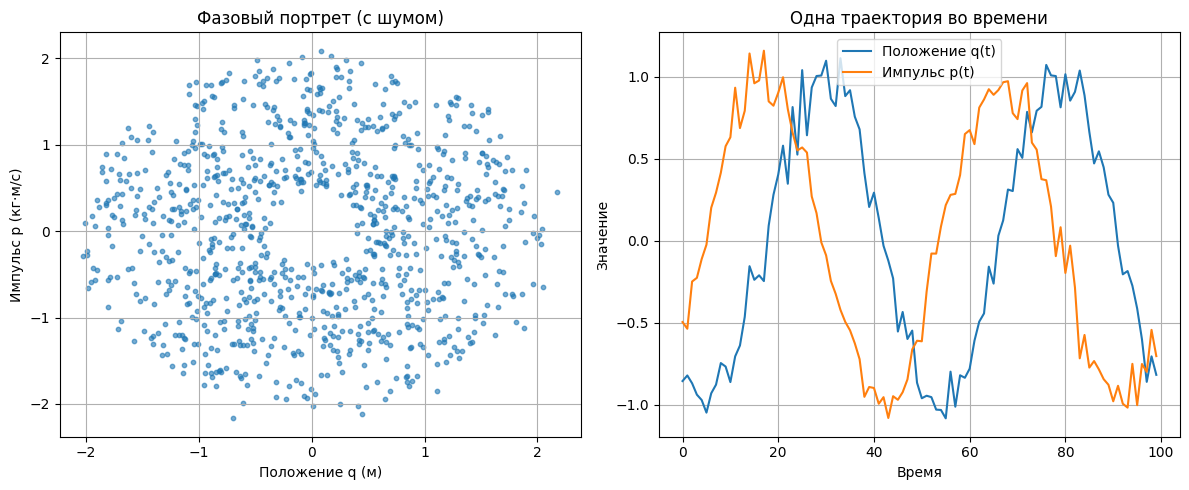

In [5]:
plt.figure(figsize=(12, 5))

# Визуализация фазового портрета
plt.subplot(1, 2, 1)
plt.scatter(coords[::10, 0], coords[::10, 1], alpha=0.6, s=10)
plt.xlabel('Положение q (м)')
plt.ylabel('Импульс p (кг·м/с)')
plt.title('Фазовый портрет (с шумом)')
plt.grid(True)

# Визуализация одной траектории во времени
plt.subplot(1, 2, 2)
traj_idx = 0  # Первая траектория
start_idx = traj_idx * 100
end_idx = start_idx + 100

plt.plot(coords[start_idx:end_idx, 0], label='Положение q(t)')
plt.plot(coords[start_idx:end_idx, 1], label='Импульс p(t)')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.title('Одна траектория во времени')
plt.legend()
plt.grid(True)
plt.savefig('generated_data.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

Epoch    0 | Train Loss: 0.897862 | Val Loss: 0.889322 | Energy: -0.7698±0.0757
Epoch  100 | Train Loss: 0.014423 | Val Loss: 0.014031 | Energy: -8.9114±0.5722
Epoch  200 | Train Loss: 0.012564 | Val Loss: 0.012304 | Energy: -9.7697±0.5777
Epoch  300 | Train Loss: 0.012420 | Val Loss: 0.012160 | Energy: -10.0095±0.5765
Epoch  400 | Train Loss: 0.012388 | Val Loss: 0.012125 | Energy: -10.0937±0.5762
Epoch  500 | Train Loss: 0.012374 | Val Loss: 0.012109 | Energy: -10.1361±0.5760
Epoch  600 | Train Loss: 0.012364 | Val Loss: 0.012098 | Energy: -10.1630±0.5759
Epoch  700 | Train Loss: 0.012356 | Val Loss: 0.012089 | Energy: -10.1861±0.5758
Epoch  800 | Train Loss: 0.012347 | Val Loss: 0.012081 | Energy: -10.2140±0.5758
Epoch  900 | Train Loss: 0.012336 | Val Loss: 0.012070 | Energy: -10.2573±0.5757


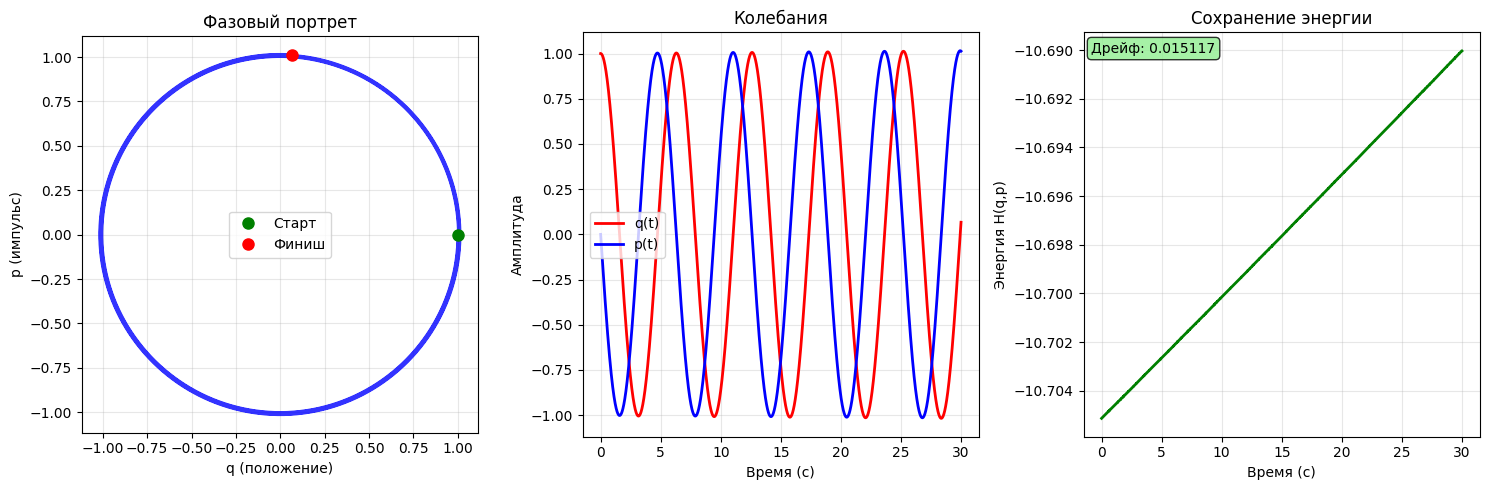

 Дрейф энергии за 30 секунд: 0.015117
 Относительный дрейф: 0.1412%


In [6]:
train_coords, val_coords, train_dynamics, val_dynamics = train_test_split(
    coords, target_dynamics, test_size=0.2, random_state=42
)

train_coords = torch.FloatTensor(train_coords)
train_dynamics = torch.FloatTensor(train_dynamics)
val_coords = torch.FloatTensor(val_coords)
val_dynamics = torch.FloatTensor(val_dynamics)

# Создаем модель
model = SimpleHNN(input_dim=2, hidden_dim=100, num_layers=3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(1000):
    # Обучающий шаг
    model.train()
    optimizer.zero_grad() #Обнуляем градиенты всех обучаемых параметров
    pred_dynamics = model(train_coords)
    loss = criterion(pred_dynamics, train_dynamics)
    loss.backward() #функция автоматического дифференцирования, вычисляющая градиенты для всех тензоров, участвовавших в вычислении loss.
    optimizer.step()

    # Валидация каждые 100 эпох
    if epoch % 100 == 0:
        model.eval() # Evaluation mode

        # НЕ используем torch.no_grad() для HNN!
        val_pred = model.predict_no_grad(val_coords)  # Используем специальный метод
        val_loss = criterion(val_pred, val_dynamics)

        # Проверяем энергию (тоже без no_grad)
        H_sample = model.hamiltonian(train_coords[:1000].detach())
        energy_mean = H_sample.mean().item()
        energy_std = H_sample.std().item()

        print(f"Epoch {epoch:4d} | Train Loss: {loss.item():.6f} | "
              f"Val Loss: {val_loss.item():.6f} | "
              f"Energy: {energy_mean:.4f}±{energy_std:.4f}")

# Тестируем долговременную динамику
model.eval()

# Интегрируем траекторию
test_coords = torch.tensor([[1.0, 0.0]], dtype=torch.float32)
trajectory = [test_coords.clone()]
energy_history = []

dt = 0.001
for step in range(30000):
    # Вычисляем энергию
    current_energy = model.hamiltonian(trajectory[-1]).item()
    energy_history.append(current_energy)

    # Получаем динамику
    dynamics = model.predict_no_grad(trajectory[-1])

    # Интегрируем (метод Эйлера)
    next_coords = trajectory[-1] + dt * dynamics
    trajectory.append(next_coords)

# Конвертируем в numpy для визуализации
trajectory = torch.stack(trajectory).squeeze().detach().numpy()
time_steps = np.arange(len(energy_history)) * dt

# Визуализация
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Фазовый портрет
ax1.plot(trajectory[:, 0], trajectory[:, 1], 'b-', linewidth=2, alpha=0.8)
ax1.plot(trajectory[0, 0], trajectory[0, 1], 'go', markersize=8, label='Старт')
ax1.plot(trajectory[-1, 0], trajectory[-1, 1], 'ro', markersize=8, label='Финиш')
ax1.set_xlabel('q (положение)')
ax1.set_ylabel('p (импульс)')
ax1.set_title('Фазовый портрет')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_aspect('equal')

# Траектория
ax2.plot(time_steps, trajectory[:-1, 0], 'r-', label='q(t)', linewidth=2)
ax2.plot(time_steps, trajectory[:-1, 1], 'b-', label='p(t)', linewidth=2)
ax2.set_xlabel('Время (с)')
ax2.set_ylabel('Амплитуда')
ax2.set_title('Колебания')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Сохранение энергии
ax3.plot(time_steps, energy_history, 'g-', linewidth=2)
ax3.set_xlabel('Время (с)')
ax3.set_ylabel('Энергия H(q,p)')
ax3.set_title('Сохранение энергии')
ax3.grid(True, alpha=0.3)

energy_drift = abs(energy_history[-1] - energy_history[0])
ax3.text(0.02, 0.95, f'Дрейф: {energy_drift:.6f}',
          transform=ax3.transAxes,
          bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.savefig('hnn_fixed_results.png', dpi=300, bbox_inches='tight')
plt.show()


print(f" Дрейф энергии за 30 секунд: {energy_drift:.6f}")
print(f" Относительный дрейф: {energy_drift/abs(energy_history[0])*100:.4f}%")